<a href="https://colab.research.google.com/github/abubakrsiddq/ImageDehazing/blob/main/models/novel/T_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import datetime
import math

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam
#from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def load_image_jpg(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (352 ,1216), antialias = True)
    img = img / 255.0
    return img

In [4]:
def load_image_png(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels = 3)
    img = tf.image.resize(img, size = (352 , 1216), antialias = True)
    img = img / 255.0
    return img

In [5]:
def dataset_preposses(orig_img_path='/content/drive/MyDrive/generated_dataset/trans',hazy_img_path='/content/drive/MyDrive/generated_dataset/hazy',percentage=0.1,validation_size=200,test_size=64,seed_val=200):
    train_img = []
    val_img = []
    
    orig_img = glob.glob(orig_img_path + '/*.jpg')
    n = len(orig_img)
    random.shuffle(orig_img)
    red_keys=orig_img[:]                                 #redundant keys to avoid key error
    train_keys = orig_img[:int(0.9*n*percentage)]
    #print(len(train_keys))
    val_keys = orig_img[-int(0.1*n*percentage):]
    #print(len(val_keys))
    split_dict = {}
    for key in red_keys:
      split_dict[key]='red'
    for key in train_keys:
      split_dict[key] = 'train'
    for key in val_keys:
      split_dict[key] = 'val'
      
    hazy_img = glob.glob(hazy_img_path + '/*.png')
    for img in hazy_img:
      img_name = img.split('/')[-1][:-4]
      orig_path = orig_img_path + '/' + img_name+'.jpg'
      if (split_dict[orig_path] == 'train'):
        train_img.append([img, orig_path])
      elif (split_dict[orig_path] == 'val'):
        val_img.append([img, orig_path])
      

    return train_img, val_img

def gen_dataset(ar):
  '''
  parameters
  list of paths
  return
  list with gt attached 
  '''
  #orig_path='/content/drive/MyDrive/generated_dataset/trans'
  #haze_pth='/content/drive/MyDrive/generated_dataset/hazy'
  lst=[]
  for i in ar:
    name=i.split('/')[-1].split('_')[0]
    pthlist=[i,orig_path+'/'+name+'.jpg']
    lst.append(pthlist)
  return lst

def data_path(orig_img_path = './drive/MyDrive/reside/archive/clear_images', hazy_img_path = './drive/MyDrive/reside/archive/haze'):
  
  (a,b)=dataset_preposses(orig_path=orig_img_path,haze_path=hazy_img_path)
  a=gen_dataset(a)
  b=gen_dataset(b)
  return a,b

In [6]:
def dataloader(train_data, val_data, batch_size):
    print(len(train_data))
    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: load_image_jpg(x))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: load_image_png(x))
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: load_image_jpg(x))
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: load_image_png(x))
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    return train, val

In [7]:
def display_img(model, hazy_img, orig_img):
    
    dehazed_img = model(hazy_img)
    #dehazed_img=np.squeeze(dehazed_img,axis=-1)
    #dehazed_img_size=dehazed_img.shape
    #dehazed_img=np.resize(dehazed_img,(dehazed_img_size[0],dehazed_img_size[1],3))
    plt.figure(figsize = (15,15))
    
    display_list = [hazy_img[0], orig_img[0], dehazed_img[0]]
    title = ['Hazy Image', 'Ground Truth trans', 'generated trans']
    
    for i in range(3):
        plt.subplot(3, 1, i+1)
        plt.title(title[i])
        #if(i==2):
        #  plt.imshow(display_list[i],cmap='gray')  
        #else:
        plt.imshow(display_list[i])
        plt.axis('off')
        directory='/content/drive/MyDrive/Test/padCheck'
        os.chdir(directory)
        filename=str(i)+'.jpg'
        #tf.keras.preprocessing.image.save_img(filename,display_list[i])
        
    plt.show()

In [8]:
model1=load_model('/content/drive/MyDrive/nets/modified_t_net/',compile=False)

class T_net(tf.keras.Model):
  def __init__(self):
    super(T_net,self).__init__()
    self.base_model=model1
    self.resize=tf.keras.layers.experimental.preprocessing.Resizing(352,1216, interpolation='bilinear')
    self.conv1 = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    #self.conv2 = Conv2D(filters = 1, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
    #               kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))

    
  def call(self,inputs):   
    #inputs = tf.keras.Input(shape = [413,550,3])
    #pad=tf.keras.layers.ZeroPadding2D(padding=(1, 1))(inputs)
    #atm=self.get_dark_channel(inputs,15)
    #atm=self.atmlight(inputs,atm)


    

    inputs=self.base_model(inputs)
    inputs=self.resize(inputs)
    conv1 = self.conv1(inputs)
    
    #conv2 = self.conv2(conv1)
    
    
    return conv1

  def model(self):
        x = Input(shape =(352, 1216, 3))
        return Model(inputs=[x], outputs=self.call(x))

  #def updt(self):
  #      self.conv1.trainable = False
  #      self.conv2.trainable = False
  #      self.conv3.trainable = False


  #def __str__(self):
  #    return "\nd1:{0}\nd2:{1}".format(self.conv4.trainable, self.conv5.trainable)
    

    
  def build_graph(self):
        x = Input(shape=(352, 1216, 3))
        return Model(inputs=[x], outputs=self.call(x))


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 352, 1216, 3)]    0         
_________________________________________________________________
model_1 (Functional)         (None, None, None, 1)     42816089  
_________________________________________________________________
resizing (Resizing)          (None, 352, 1216, 1)      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 352, 1216, 3)      30        
Total params: 42,816,119
Trainable params: 42,657,719
Non-trainable params: 158,400
_________________________________________________________________


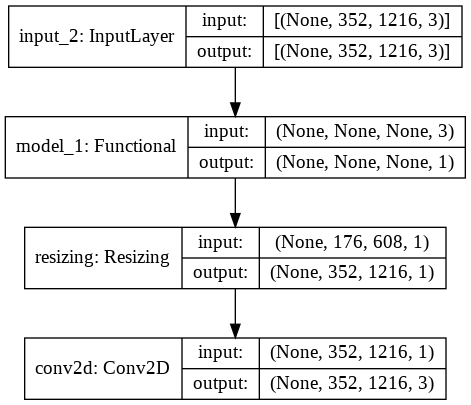

In [9]:


model=T_net()

model.model().summary()
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model.build_graph(), to_file=dot_img_file, show_shapes=True)



In [ ]:
from tensorflow.keras.layers import Conv2D, UpSampling2D, LeakyReLU, Concatenate
from tensorflow.keras import Model


import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import datetime


import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.applications import DenseNet169

class UpscaleBlock(Model):
    def __init__(self, filters, name):      
        super(UpscaleBlock, self).__init__()
        self.up = UpSampling2D(size=(2, 2), interpolation='bilinear', name=name+'_upsampling2d')
        self.concat = Concatenate(name=name+'_concat') # Skip connection        
        self.convA = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', name=name+'_convA')
        self.reluA = LeakyReLU(alpha=0.2)
        self.convB = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', name=name+'_convB')
        self.reluB = LeakyReLU(alpha=0.2)
    
    def call(self, x):        
        b = self.reluB( self.convB( self.reluA( self.convA( self.concat( [self.up(x[0]), x[1]] ) ) ) ) )
        return b 

    #def model(self):
    #    x = Input(shape = (412, 548, 3))
    #    return Model(x=[x], outputs=self.call(x))
#
    #
    #def build_graph(self):
    #    x = Input(shape=(412, 548, 3))
    #    return Model(x=[x], outputs=self.call(x))


class Encoder(Model):
    def __init__(self):
        super(Encoder, self).__init__()                
        self.base_model = DenseNet169(input_shape=(None, None, 3), include_top=False)   
        print('Base model loaded {}'.format(DenseNet169.__name__))
        
        # Create encoder model that produce final features along with multiple intermediate features
        outputs = [self.base_model.outputs[-1]]
        for name in ['pool1', 'pool2_pool', 'pool3_pool', 'conv1/relu'] : outputs.append( self.base_model.get_layer(name).output )        
        self.encoder = Model(inputs=self.base_model.inputs, outputs=outputs)
        
    def call(self, x):

        return self.encoder(x)

    #def model(self):
    #    x = Input(shape = (412, 548, 3))
    #    #return Model(inputs=[x], outputs=self.call(x))
    #    return Model(x=[x], outputs=self.call(x))
#
    #
    #def build_graph(self):
    #    x = Input(shape=(412, 548, 3))
    #    #return Model(inputs=[x], outputs=self.call(x))
    #    return Model(x=[x], outputs=self.call(x))


class Decoder(Model):
    def __init__(self, decode_filters):
        super(Decoder, self).__init__()        
        self.conv2 =  Conv2D(filters=decode_filters, kernel_size=1, padding='same', name='conv2')        
        self.up1 = UpscaleBlock(filters=decode_filters//2,  name='up1')
        self.up2 = UpscaleBlock(filters=decode_filters//4,  name='up2')
        self.up3 = UpscaleBlock(filters=decode_filters//8,  name='up3')
        self.up4 = UpscaleBlock(filters=decode_filters//16, name='up4')        
        self.conv3 = Conv2D(filters=1, kernel_size=3, strides=1, padding='same', name='conv3')       
        

    def call(self, features):        
        x, pool1, pool2, pool3, conv1 = features[0], features[1], features[2], features[3], features[4]
        up0 = self.conv2(x)        
        up1 = self.up1([up0, pool3])        
        up2 = self.up2([up1, pool2])        
        up3 = self.up3([up2, pool1])        
        up4 = self.up4([up3, conv1])        
        up4=self.conv3( up4 )
        return ReLU(max_value = 1.0)(up4)

    #def model(self):
    #    x = Input(shape = (412, 548, 3))
    #    return Model(features=[x], outputs=self.call(x))
#
    #
    #def build_graph(self):
    #    x = Input(shape=(412, 548, 3))
    #    return Model(features=[x], outputs=self.call(x))
    
class DepthEstimate(Model):
    def __init__(self):
        super(DepthEstimate, self).__init__()
        self.encoder = Encoder()
        print( int(self.encoder.layers[-1].output[0].shape[-1]  ))
        self.decoder = Decoder( decode_filters = int(self.encoder.layers[-1].output[0].shape[-1]  ) )
        self.inc_size=tf.keras.layers.UpSampling2D( size=(2, 2), data_format=None, interpolation='bilinear')
        
        print('\nModel created.')

    def call(self, x):
        x=self.inc_size(self.decoder( self.encoder(x) ))
        return tf.keras.layers.concatenate([x,x,x],axis=-1)

    def model(self):
        x = Input(shape = (352, 1216, 3))
        return Model(inputs=[x], outputs=self.call(x))
        
    
    def build_graph(self):
       x = Input(shape = (352, 1216, 3))
       return Model(inputs=[x], outputs=self.call(x))


In [ ]:
model=DepthEstimate()
model.load_weights('/content/drive/MyDrive/nets/modified_t_net/weights/')

Base model loaded DenseNet169
1664

Model created.


In [ ]:

model.model().summary()
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model.build_graph(), to_file=dot_img_file, show_shapes=True)

In [10]:
tnet=T_net()

In [20]:
# Hyperparameters
epochs = 2
batch_size = 4
k_init = tf.keras.initializers.random_normal(stddev=0.008, seed = 101)      
regularizer = tf.keras.regularizers.L2(1e-4)
b_init = tf.constant_initializer()

#train_data, val_data = dataset_preposses(orig_img_path = '/content/drive/MyDrive/generated_dataset/trans', hazy_img_path = '/content/drive/MyDrive/generated_dataset/hazy')
train_data, val_data = dataset_preposses(orig_img_path = '/content/drive/MyDrive/kitti/trans', hazy_img_path = '/content/drive/MyDrive/kitti/hazy',percentage=0.3)
train, val = dataloader(train_data, val_data, batch_size)
#tnet = model
#tnet = tf.keras.models.load_model('/content/drive/MyDrive/nets/dehazenet',compile=False)

optimizer = Adam(learning_rate = 1e-7)

train_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")


1620


In [16]:
def train_model_enhance(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer):
    
    for epoch in range(epochs):
        
        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        start_time_step = time.time()
        
        # training loop
        
        for step, (train_batch_haze, train_batch_orig) in enumerate(train):

            with tf.GradientTape() as tape:

                train_logits = net(train_batch_haze, training = True)
                #loss = mean_squared_error(train_batch_orig, train_logits)
                #loss=tf.image.psnr(train_batch_orig, train_logits, max_val=1)
                
                loss=tf.keras.losses.mean_absolute_error(train_batch_orig, train_logits)#.numpy

            grads = tape.gradient(loss, net.trainable_weights)
            optimizer.apply_gradients(zip(grads, net.trainable_weights))

            train_loss_tracker.update_state(train_batch_orig, train_logits)
            if step == 0:
                print('[', end='')
            if step % 64 == 0:
                print('=', end='')
        
        print(']', end='')
        print('  -  ', end='')
        print('Training Loss: %.4f' % (train_loss_tracker.result()), end='')
        
        # validation loop
        
        for step, (val_batch_haze, val_batch_orig) in enumerate(val):
            val_logits = net(val_batch_haze, training = False)
            val_loss_tracker.update_state(val_batch_orig, val_logits)
            
            if step % 64 ==0:
                display_img(net, val_batch_haze, val_batch_orig)
        
        print('  -  ', end='')
        print('Validation Loss: %.4f' % (val_loss_tracker.result()), end='')
        print('  -  ', end=' ')
        print("Time taken: %.2fs" % (time.time() - start_time_epoch))
        
        #net.save('/content/drive/MyDrive/nets/t_net/trained_model')           # save the model(variables, weights, etc)
        train_loss_tracker.reset_states()
        val_loss_tracker.reset_states()


Start of epoch 0 [=======]  -  Training Loss: 0.0022

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


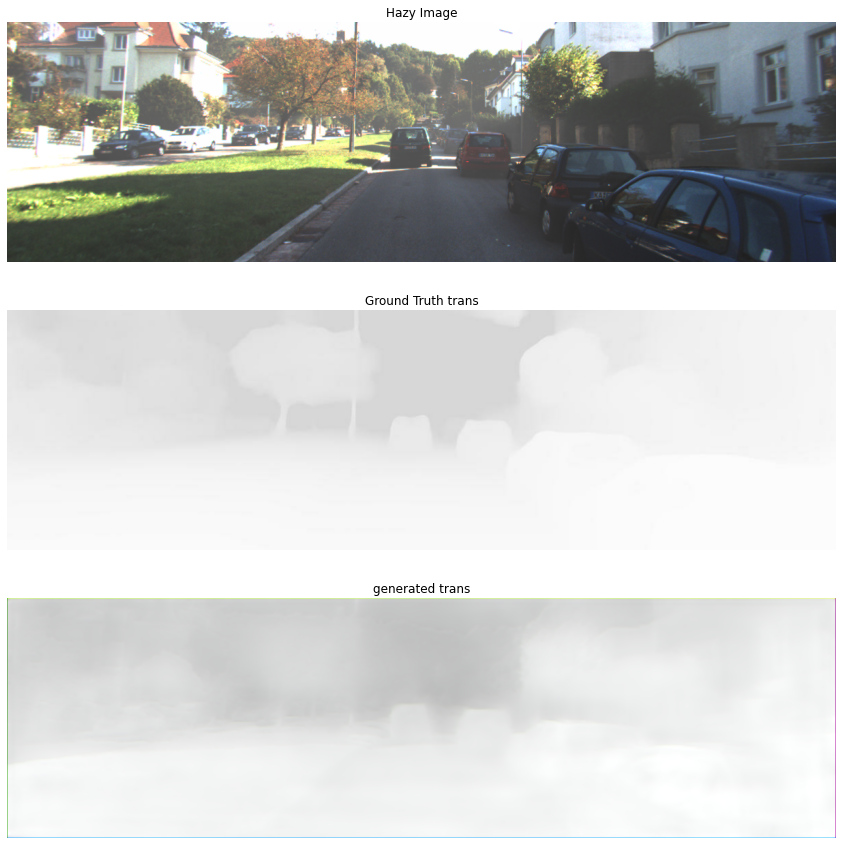

  -  Validation Loss: 0.0021  -   Time taken: 1197.74s

Start of epoch 1 [=======]  -  Training Loss: 0.0021

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


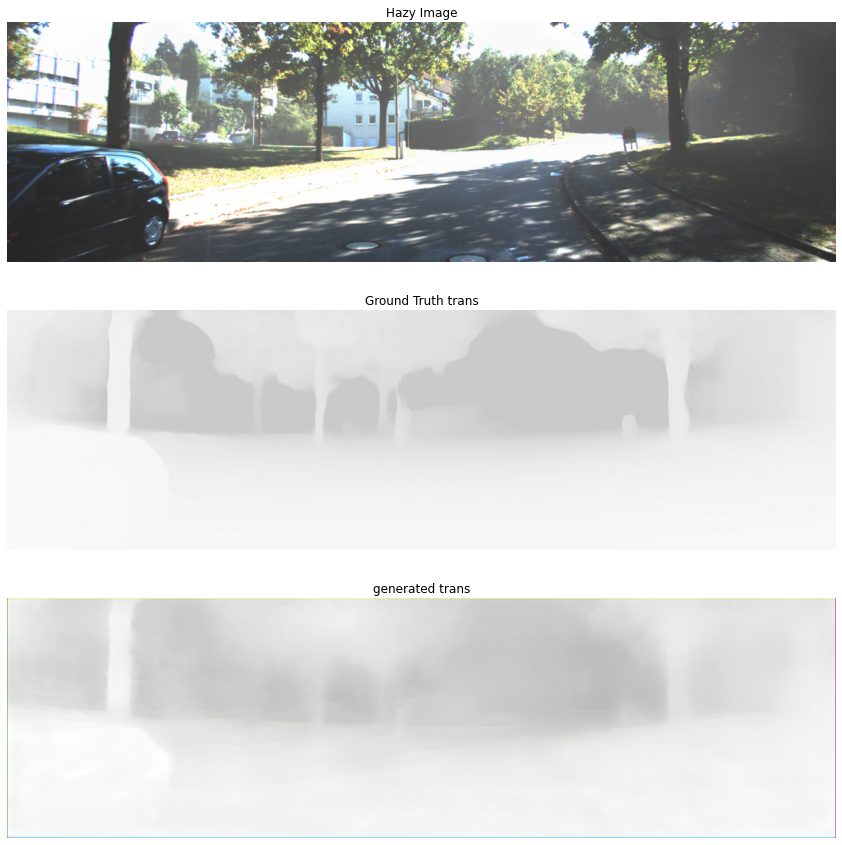

  -  Validation Loss: 0.0021  -   Time taken: 427.25s

Start of epoch 2 [=======]  -  Training Loss: 0.0021

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


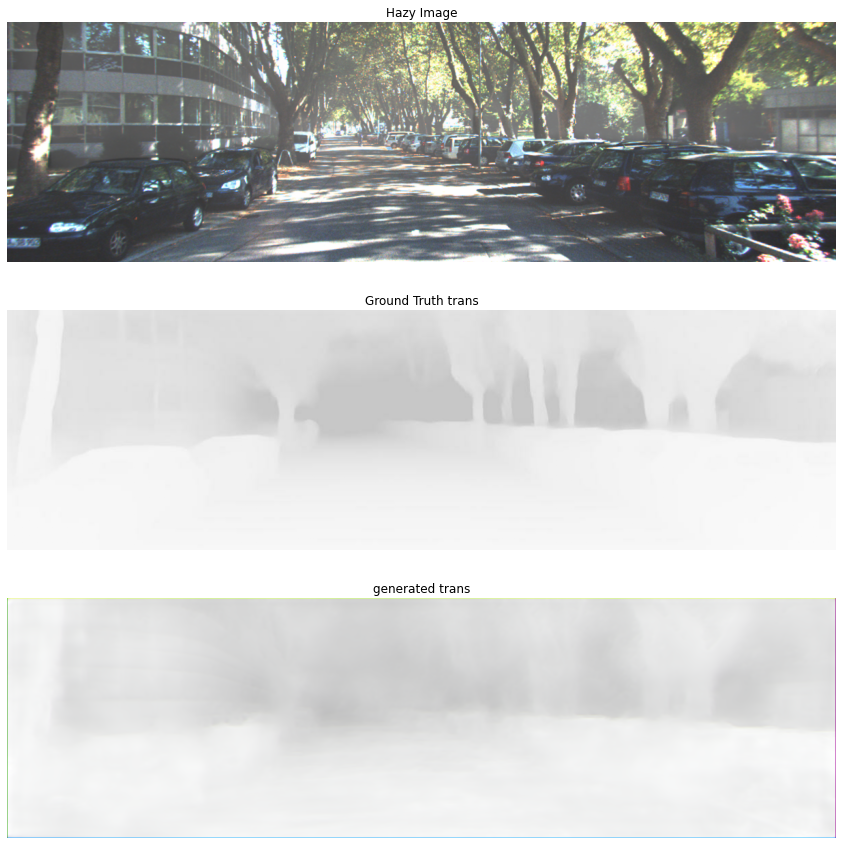

  -  Validation Loss: 0.0021  -   Time taken: 430.31s
CPU times: user 19min 47s, sys: 1min 40s, total: 21min 28s
Wall time: 34min 15s


In [21]:
%%time
#net= tf.keras.models.load_model('/content/drive/MyDrive/nets/multihaze',compile=False)
train_model_enhance(3, train, val,tnet,train_loss_tracker, val_loss_tracker, optimizer)

In [ ]:
tnet.save_weights('/content/drive/MyDrive/nets/prelim_model/t_net/weights/')
tnet.save('/content/drive/MyDrive/nets/prelim_model/t_net/')
